# Excersice wirh 2R Robot

Reference for end-effector is a dot in plane. We have to make an inverse kinematics and find Theta_1 and Theta_2. Also make a PD controller

Import necessery libraries

In [2]:
import mujoco
import mujoco_viewer
import matplotlib.pyplot as plt
import numpy as np

Create model and data

In [3]:
model = mujoco.MjModel.from_xml_path('2r_robot_PID.xml')
data = mujoco.MjData(model)

Create a FUNCTION 'set_torque' where we use PD controller for our joints actuators.

In [4]:
def set_torque(mj_data, KP, KV, theta_1, theta_2): 
    data.ctrl[0] = KP * (-mj_data.qpos[0] + theta_1) + KV * (0 - mj_data.qvel[0])
    data.ctrl[1] = KP * (-mj_data.qpos[1] + theta_2) + KV * (0 - mj_data.qvel[1])

Set initial angles and links' length. Values in radians (rad). Note that 1rad=pi=180 deg

In [6]:
theta_1 = 1.9 # initial angle of first joint
theta_2 = -2.42 # initial angle of second joint
data.joint('joint_1').qpos[0] = theta_1 
data.joint('joint_2').qpos[0] = theta_2 

l_1 = 1 # first link lenght
l_2 = 1 # second link lenght

Referense is dot in plane $XY=(0.75, 0.5)$ . Here we need arrays with the dimension of the 'time' vector, so we use np.repeat() for it.

In [7]:
SIMEND = 10
TIMESTEP = 0.002
STEP_NUM = int(SIMEND/TIMESTEP)

x_ref = np.repeat(0.75, STEP_NUM)
z_ref = np.repeat(0.5, STEP_NUM)

Create empty lists for data

In [9]:
EE_position_x = [] # empty lists for actual position of end-effector
EE_position_z = []

Make a viewer. Into FOR loop find Theta_1 and Theta_2 using trigonometry

In [18]:
viewer = mujoco_viewer.MujocoViewer(model, data,
                                    title="2R_robot",
                                    width=1920,
                                    height=1080)

for i in range(STEP_NUM):
    if viewer.is_alive:

        # Find alpha, beta, gamma
        x = x_ref[i]
        z = z_ref[i]
        alpha_numerator = x**2 + z**2 + l_1**2 - l_2**2
        alpha_denumerator = 2 * l_1 * np.sqrt(x**2 + z**2)
        alpha = np.arccos(alpha_numerator/alpha_denumerator)
        
        beta_numerator = l_1**2 + l_2**2 - x**2 - z**2
        beta_denumerator = 2 * l_1 * l_2
        beta = np.arccos(beta_numerator/beta_denumerator)
        
        gamma = np.arctan2(x, z)

        # Find theta_1 and theta_2
        theta_1 = alpha - gamma
        theta_2 = beta - np.pi

        # Use control
        set_torque(data, 15, 6, theta_1, theta_2)

        # Writing values of actual end-effector's position from data to empty lists
        position_EE = data.site_xpos[0]
        EE_position_x.append(position_EE[0])
        EE_position_z.append(position_EE[2])

        mujoco.mj_step(model, data)

        viewer.render()
    else:
        break

viewer.close()

Let's output graphs of the reference point and the actual position

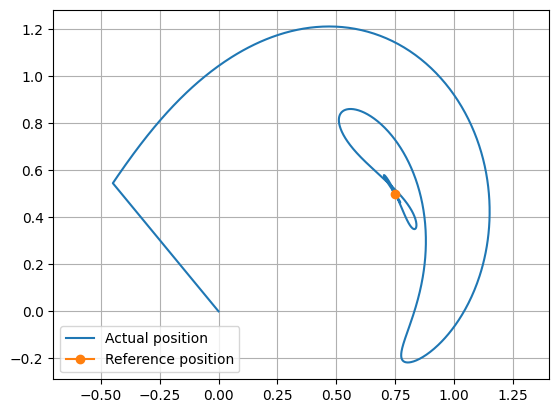

In [19]:
plt.plot(EE_position_x, EE_position_z, label='Actual position')
plt.plot(x_ref[0], z_ref[0], label='Reference position', marker='o')
plt.legend()
plt.axis('equal')
plt.grid()
plt.show()